In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [113]:
'''
Data
'''

state = gpd.read_file('Data/Geometry/california.shp')
counties = gpd.read_file('Data/Geometry/california_counties.shp')

atlas = nice.graph.graph_from_json('Data/atlas.json')
atlas = nice.graph.giant_connected_component(atlas)

reduced_atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

stations = nice.graph.graph_from_json('Data/stations.json')

places = nice.graph.graph_from_json('Data/places_50k.json')

In [114]:
'''
Defining the corridor outline
'''
deep_reload(nice)

termini = nice.graph.subgraph(
    places, ['Sacramento, CA', 'Santa Clarita, CA', 'Fresno, CA'],
)

graph_to_atlas, atlas_to_graph = nice.graph.node_assignment(
    atlas, termini
)

selection = []

for origin in termini.nodes:
    for destination in termini.nodes:
        
        path = nx.shortest_path(
            atlas,
            graph_to_atlas[origin],
            target = graph_to_atlas[destination],
            weight = 'time',
        )

        selection.extend(path)

selection = list(np.unique(selection))

corridor = nice.graph.subgraph(atlas, selection)

In [115]:
'''
Defining the corridor atlas
'''
deep_reload(nice)

from shapely import Polygon
from shapely import affinity

pairs = [
    ('Sacramento, CA', 'Santa Clarita, CA'),
    ('Santa Clarita, CA', 'Fresno, CA'),
    ('Fresno, CA', 'Sacramento, CA'),
]

coords = []

for pair in pairs:

    path = nx.shortest_path(
        atlas,
        graph_to_atlas[pair[0]],
        target = graph_to_atlas[pair[1]],
        weight = 'time',
    )
    

    coords.extend(
        [(atlas._node[path[i - 1]]['x'], atlas._node[path[i]]['y']) \
         for i in range(1, len(path))]
    )

polygon = Polygon(coords)
scaled_polygon = affinity.scale(polygon, xfact = 1.05, yfact = 1.05)

x = [n['x'] for n in atlas._node.values()]
y = [n['y'] for n in atlas._node.values()]
k = np.array(list(atlas.nodes))

in_corridor = nice.in_polygon.points_in_polygon(scaled_polygon, x, y)

corridor_roads = nice.graph.subgraph(atlas, k[in_corridor])

corridor_atlas = nice.graph.supergraph((corridor, corridor_roads))
corridor_atlas = nice.graph.giant_connected_component(corridor_atlas)

In [116]:
'''
Corridor places and stations
'''
deep_reload(nice)

relation_stations = nice.graph.relate(corridor_atlas, stations)

corridor_stations = nice.graph.subgraph(
    stations, [r['id_graph'] for r in relation_stations if r['distance'] <= 5e3]
)

relation_places = nice.graph.relate(corridor_atlas, places)

corridor_places = nice.graph.subgraph(
    places, [r['id_graph'] for r in relation_places if r['distance'] <= 5e3]
)

In [250]:
'''
Station candidate locations
'''
deep_reload(nice)

origins = list(
    np.unique(
        [r['id_atlas'] for r in relation_stations if r['distance'] <= 5e3] +
        [r['id_atlas'] for r in relation_places if r['distance'] <= 5e3]
    )
)

candidate_locations = nice.graph.reduction(
    corridor_atlas,
    # origins = origins,
    objective = 'distance',
    # maximum_cost = 20e3,
)

In [256]:
list(corridor_atlas.edges())[0]

(6054, 6055)

In [259]:
corridor_atlas._adj[6054][6055]

{'distance': 420.0,
 'speed': 28.88888888888889,
 'time': 14.538461538461538,
 'price': 0,
 'roadnum': 'S99'}

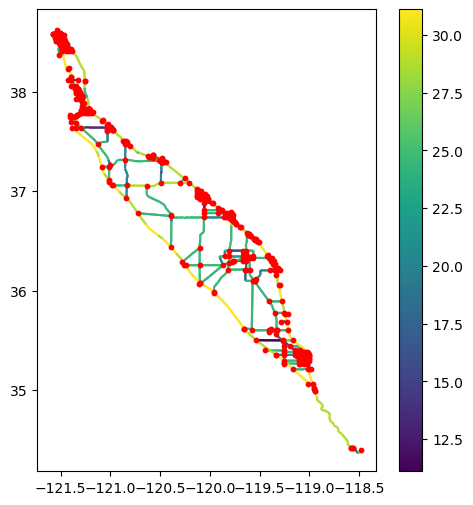

In [264]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'plot': {
        'color': 'red',
        's': 5,
        'zorder': 2,
    },
}
    
# _ = nice.plot.plot_nodes(corridor_stations, ax = ax, **kw)

kw = {
    'plot': {
        'color': 'blue',
        's': 5,
        'zorder': 3,
    },
}
    
# _ = nice.plot.plot_nodes(places, ax = ax, **kw)

kw = {
    'plot': {
        'color': 'red',
        's': 10,
        'zorder': 3,
    },
}
    
_ = nice.plot.plot_nodes(candidate_locations, ax = ax, **kw)

kw = {
    'field': 'speed',
    'plot': {  
        'color': 'black',
        'zorder': 1,
    },
    'colorbar': {}
}
    
_ = nice.plot.plot_edges(corridor_atlas, ax = ax, **kw)

ax.set_aspect('equal')

In [265]:
nice.graph.graph_to_json(corridor_atlas, 'Data/corridor_atlas.json')
nice.graph.graph_to_json(corridor_stations, 'Data/corridor_stations.json')
nice.graph.graph_to_json(corridor_places, 'Data/corridor_places.json')
nice.graph.graph_to_json(candidate_locations, 'Data/candidate_locations.json')

In [228]:
'''
Closest corridor place
'''

graph_to_atlas, atlas_to_graph = nice.graph.node_assignment(
    atlas, places
)

origins = [graph_to_atlas[p] for p in corridor_places.nodes]

costs, values, paths = nice.graph.dijkstra(
    atlas, origins = origins, objective = 'time', fields = ['time', 'distance'],
)

In [243]:
for source, node in corridor_places._node.items():

    s = graph_to_atlas[source]

    node['places'] = {}

    for k, v in places._node.items():

        t = graph_to_atlas[k]
        
        if paths[t][0] == s:

            node['places'][k] = {'population': v['population'], **values[t]}

In [198]:
# {p: costs[graph_to_atlas[p]] / 3600 for p in places.nodes}
entry_values = (
    {p: values[graph_to_atlas[p]] for p in places.nodes}
)

entry_points = (
    {p: atlas_to_graph[paths[graph_to_atlas[p]][0]][0] for p in places.nodes}
)

# entry_points

In [206]:
d = {k: [] for k in corridor_places.nodes}
w = {k: [] for k in corridor_places.nodes}

for k, v in entry_values.items():

    d[entry_points[k]].append(v['distance'])
    w[entry_points[k]].append(places._node[k]['population'])

(array([      0.,  697864., 1588773.,  853964.,  640304., 2147217.,
        3135792., 2904864., 4680927.,  227123.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

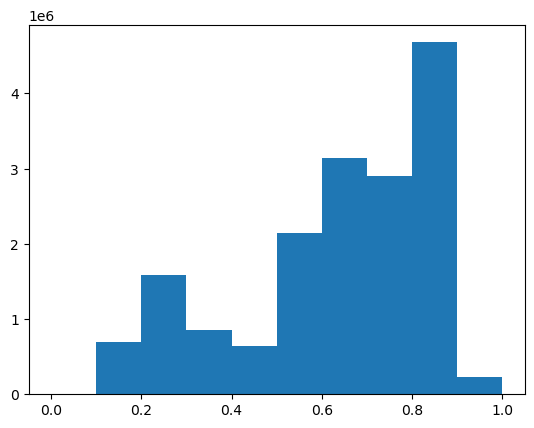

In [218]:
p = 'Tracy, CA'
p = 'Santa Clarita, CA'
# p = 'Sacramento, CA'
# p = 'Bakersfield, CA'

plt.hist(
    1 - np.array(d[p]) / 300e3,
    weights = w[p],
    bins = np.linspace(0, 1, 11),
    # density = True,
)

In [245]:
'''
Making the corridor graph
'''

corridor_graph = nice.graph.supergraph([corridor_places, corridor_stations])

corridor_graph = nice.graph.adjacency(
    corridor_atlas, corridor_graph, objective = 'time'
)

 [--------->] (409/409) 100.00%, 16.26 it/s, 25.21 s elapsed, 0.00 s remaining

In [246]:
nice.graph.graph_to_json(corridor_graph, 'Data/corridor_graph.json')

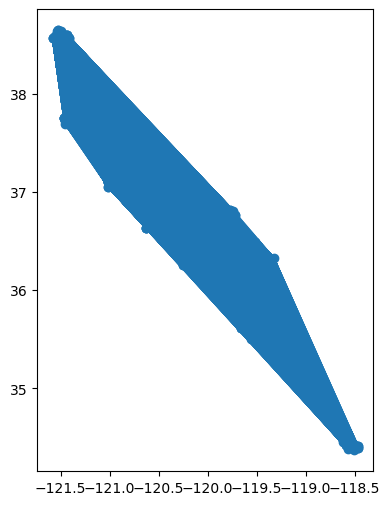

In [224]:
fig, ax = plt.subplots(figsize = (6, 6))

kw = {
    'edges': {},
    'nodes': {},
    # 'plot': {
    #     'color': 'black',
    #     'zorder': 1,
    # },
}
    
_ = nice.plot.plot_graph(corridor_graph, ax = ax, **kw)

ax.set_aspect('equal')